In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, Reshape, multiply
from tensorflow.keras.models import Sequential, load_model, Model

# 체크포인트를 만드는 라이브러리 부분 임포트
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [2]:
#=============================
import random as rn

seed_num = 0
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
#=============================

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU Found")

# Create a TensorFlow session
with tf.Session() as sess:
    # Run a simple computation on the GPU
    with tf.device('/device:GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
        b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
        c = tf.matmul(a, b)

        # Initialize the variables
        init = tf.global_variables_initializer()

        # Run the initialization
        sess.run(init)

        # Print the result of the computation
        print(sess.run(c))

Instructions for updating:
non-resource variables are not supported in the long term
Default GPU Device: /device:GPU:0
[[22. 28.]
 [49. 64.]]


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [7]:
with_helmet = os.listdir('./data/with_helmet_resize_64/')
without_helmet = os.listdir('./data/without_helmet_resize_64/')

In [8]:
image_data_label = [(cv2.imread('./data/with_helmet_resize_64/'+i),1) for i in with_helmet] + [(cv2.imread('./data/without_helmet_resize_64/'+ i),0) for i in without_helmet]

In [9]:
rn.shuffle(image_data_label)

In [10]:
data = [i[0] for i in image_data_label]
label = [i[1] for i in image_data_label]

In [11]:
data = np.array(data)
label = np.array(label)

In [12]:
data.shape

(20000, 64, 64, 3)

In [13]:
data = data.astype('float32') / 255

In [14]:
def Residual_Block_50(x, filters):
    f1, f2 = filters
    x_skip = x 

    x = Conv2D(f1, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f1, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size=(1,1), strides=1, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = Conv2D(f2, kernel_size=(1,1),strides=(1,1),padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)  

    x = add([x, x_skip])
    x = Activation('relu')(x)    
    return x

In [15]:

inputs = Input(shape=(64,64,3))
x = Conv2D(64, kernel_size=7, strides=2, padding='valid')(inputs)
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

for i in range(3):
  x = Residual_Block_50(x, filters=(64,256)) 

for i in range(4):
  x = Residual_Block_50(x, filters =(128,512)) 

for i in range(6):
  x = Residual_Block_50(x, filters =(256,1024)) 

for i in range(3):
  x = Residual_Block_50(x, filters =(512,2048)) 



# x = Residual_Block(x, filter = 64)
# x = Residual_Block(x, filter = 64)

# x = Residual_Block(x, filter = 128)
# x = Residual_Block(x, filter = 128)

# x = Residual_Block(x, filter = 256)
# x = Residual_Block(x, filter = 256)

# x = Residual_Block(x, filter = 512)
# x = Residual_Block(x, filter = 512)


x = GlobalAveragePooling2D()(x) 


outputs = Dense(1, activation = 'sigmoid')(x)



Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 29, 29, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 15, 15, 64)   4160        ['max_pooling2d[0][0]']          
                                                                                              

In [50]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelpath = './model/'
checkpointer = ModelCheckpoint(filepath = modelpath + 'ResNet_50.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=10)

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 42)

In [52]:
history = model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs = 100,  batch_size = 32, callbacks = [checkpointer, early_stopping_callback])

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - ETA: 0s - loss: 0.3606 - acc: 0.8489

c:\Users\SBAUser\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.29817, saving model to ./model\ResNet_50.hdf5
16000/16000 [==============================] - 131s 8ms/sample - loss: 0.3606 - acc: 0.8489 - val_loss: 0.2982 - val_acc: 0.9040
Epoch 2/100
16000/16000 [==============================] - ETA: 0s - loss: 0.2347 - acc: 0.9059
Epoch 2: val_loss did not improve from 0.29817
16000/16000 [==============================] - 107s 7ms/sample - loss: 0.2347 - acc: 0.9059 - val_loss: 0.3536 - val_acc: 0.8928
Epoch 3/100
16000/16000 [==============================] - ETA: 0s - loss: 0.1915 - acc: 0.9267
Epoch 3: val_loss did not improve from 0.29817
16000/16000 [==============================] - 108s 7ms/sample - loss: 0.1915 - acc: 0.9267 - val_loss: 0.3756 - val_acc: 0.9080
Epoch 4/100
16000/16000 [==============================] - ETA: 0s - loss: 0.1733 - acc: 0.9352
Epoch 4: val_loss improved from 0.29817 to 0.18043, saving model to ./model\ResNet_50.hdf5
16000/16000 [==============================] - 108s 

In [64]:
acc = history.history['acc']
len(acc)

55

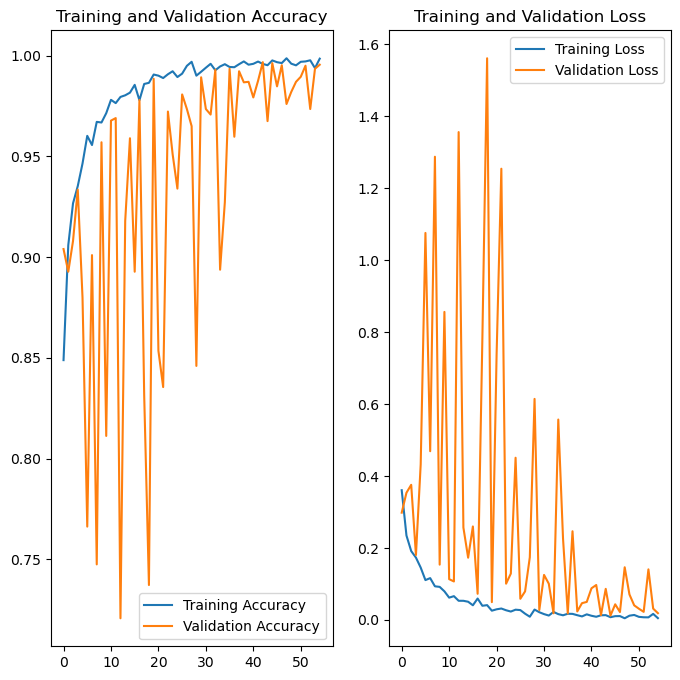

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(acc)), loss, label='Training Loss')
plt.plot(range(len(acc)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
y_pred = np.round(model.predict(x_test))
y_pred

c:\Users\SBAUser\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [55]:
model.evaluate(x_test,y_test)[1]

0.9955

In [56]:
f1 = f1_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)

print(f1, pre)

0.9955246146195922 0.9935483870967742


In [57]:
df = pd.read_csv('./models.csv')
df

,model,accuracy(%),image_size,eopchs,batchsize,f1_score(%),precision_score(%)
0,VGG_16_KFold,99.24,"(128, 128)",100,64,99.24,99.16
1,VGG_16,99.28,"(128, 128)",100,64,97.54,98.13
2,googLeNet_Semodule,99.86,"(64,64)",50,32,99.18,99.64


In [58]:
df.loc[3] = ['ResNet_50', round(model.evaluate(x_test,y_test)[1]*100,2),
             (64, 64), 100, 32,
             round(f1*100, 2), round(pre*100, 2)]

df

,model,accuracy(%),image_size,eopchs,batchsize,f1_score(%),precision_score(%)
0,VGG_16_KFold,99.24,"(128, 128)",100,64,99.24,99.16
1,VGG_16,99.28,"(128, 128)",100,64,97.54,98.13
2,googLeNet_Semodule,99.86,"(64,64)",50,32,99.18,99.64
3,ResNet_50,99.55,"(64, 64)",100,32,99.55,99.35


In [59]:
df.to_csv('./models.csv', index = False)

In [16]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

idx = 1

fold_accuracy = {}
fold_f1 = {}
fold_pre = {}
for train, val in kf.split(data,label) :
    
    print(f'{idx}fold')
    
    model = Model(inputs=inputs, outputs=outputs)
        
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    modelpath = './model/'
    if not os.path.exists(modelpath) :
        os.mkdir(modelpath)

    checkpointer = ModelCheckpoint(filepath = modelpath + f'ResNet_50_kfold_{idx}.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True)
    
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=10)

    history = model.fit(data[train], label[train], validation_data=[data[val], label[val]], epochs = 50,  batch_size = 8, callbacks = [checkpointer, early_stopping_callback], verbose = 0)
    
    best_model = load_model(f'./model/ResNet_50_kfold_{idx}.hdf5')
    # 정확도(accuracy)
    print('정확도(accuracy) : ', best_model.evaluate(data[val], label[val])[1])
    
    y_pred = np.round(best_model.predict(data[val]))
    
    fold_accuracy[f'{idx}fold'] = best_model.evaluate(data[val], label[val])[1]
    
    fold_f1[f'{idx}fold'] = round(f1_score(label[val], y_pred)*100,2)
    
    fold_pre[f'{idx}fold'] = round(precision_score(label[val], y_pred)*100, 2)
    
    idx += 1


1fold


c:\Users\SBAUser\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.00072, saving model to ./model\ResNet_50_kfold_1.hdf5

Epoch 2: val_loss did not improve from 1.00072

Epoch 3: val_loss improved from 1.00072 to 0.65447, saving model to ./model\ResNet_50_kfold_1.hdf5

Epoch 4: val_loss did not improve from 0.65447

Epoch 5: val_loss improved from 0.65447 to 0.21523, saving model to ./model\ResNet_50_kfold_1.hdf5

Epoch 6: val_loss did not improve from 0.21523

Epoch 7: val_loss did not improve from 0.21523

Epoch 8: val_loss did not improve from 0.21523

Epoch 9: val_loss did not improve from 0.21523

Epoch 10: val_loss did not improve from 0.21523

Epoch 11: val_loss improved from 0.21523 to 0.15005, saving model to ./model\ResNet_50_kfold_1.hdf5

Epoch 12: val_loss improved from 0.15005 to 0.13919, saving model to ./model\ResNet_50_kfold_1.hdf5

Epoch 13: val_loss did not improve from 0.13919

Epoch 14: val_loss did not improve from 0.13919

Epoch 15: val_loss did not improve from 0.13919

Epoch 16: val_los